In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd

import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Import code from src
sys.path.insert(0, '../src/')
from isingmodel import bias_variance, generate_1Ddata
from linearmodel import OLS, Lasso, Ridge
from project_tools import fig_path

In [3]:
# set up Regression models
ols = OLS(fit_intercept=False)
ridge = Ridge(fit_intercept=False)
lasso = Lasso(fit_intercept=False)

In [4]:
# generate data
np.random.seed(42)
L = 40     # system size
N = 10000  # number of points
data, target = generate_1Ddata(L, N)
#target = target + np.random.normal(0, 4.0, size=N)

X_train, X_test, y_train, y_test = ols.split_data(data, target, 0.96)

(10000, 1600)


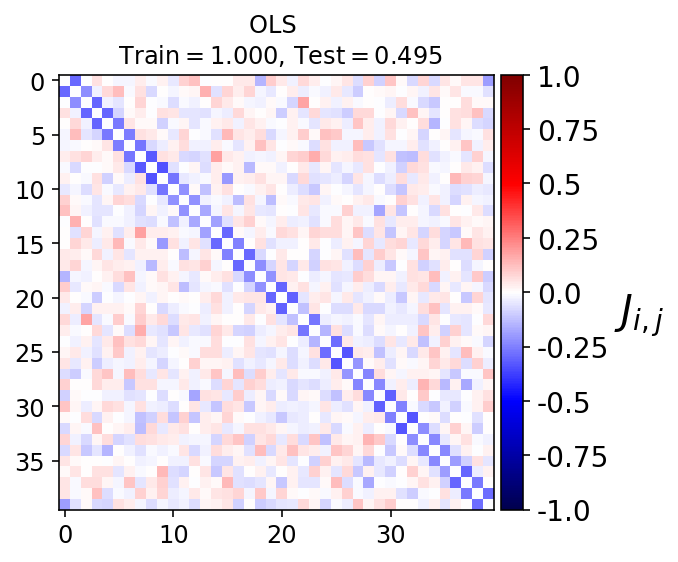

In [5]:
ols.fit(X_train, y_train)  # fit model

J_ols = np.array(ols.coef_).reshape((L, L))

cmap_args = dict(vmin=-1., vmax=1., cmap='seismic')
fig, ax0 = plt.subplots()

im = ax0.imshow(J_ols, **cmap_args)
ax0.set_title('OLS \n Train$={:.3f}$, Test$={:.3f}$'.format(
    ols.r2(X_train, y_train), ols.r2(X_test, y_test)))

divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_yticklabels(np.arange(-1.0, 1.0 + 0.25, 0.25), fontsize=14)
cbar.set_label('$J_{i,j}$', labelpad=15, y=0.5, fontsize=20, rotation=0)

fig.savefig(fig_path("ising_J_ols.pdf"), bbox_inches='tight')
plt.show()

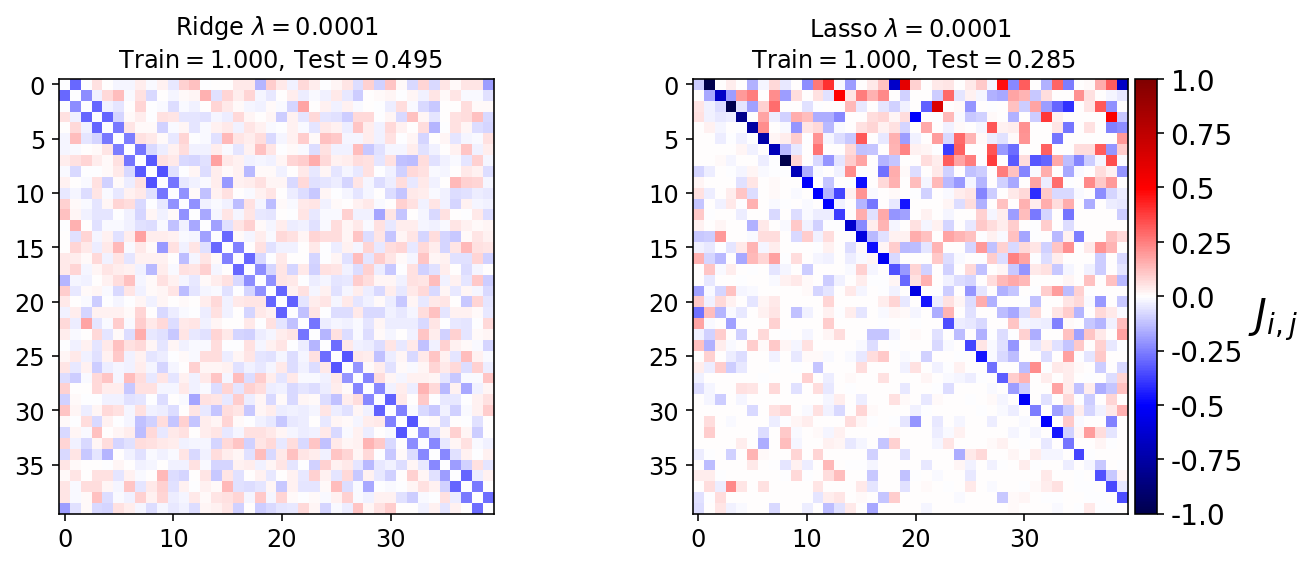

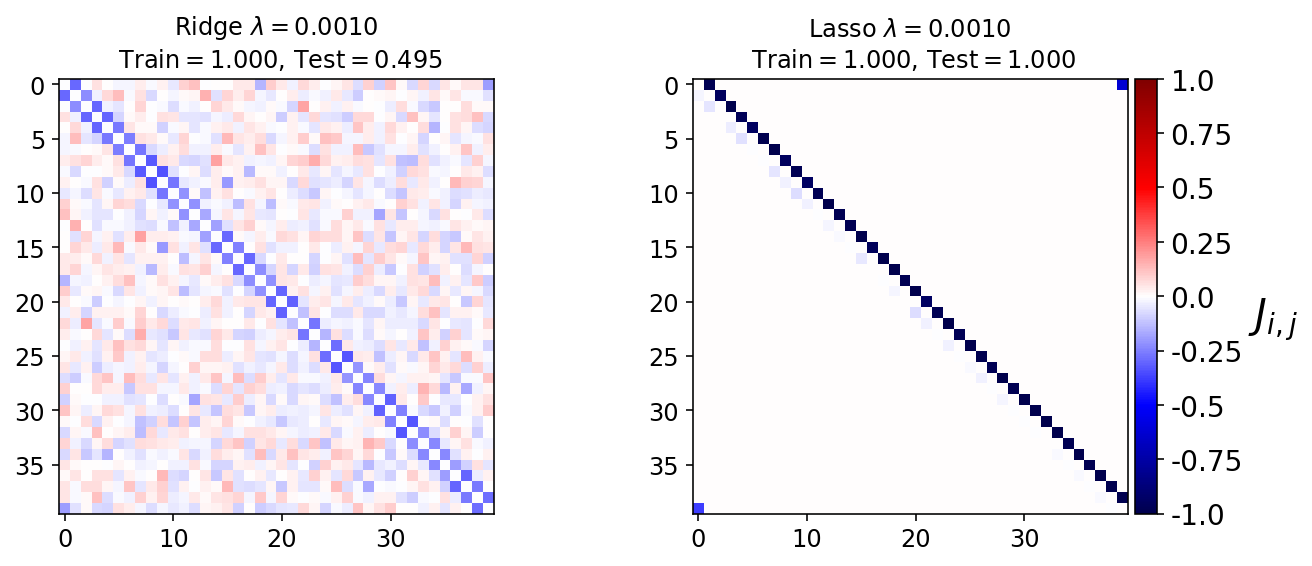

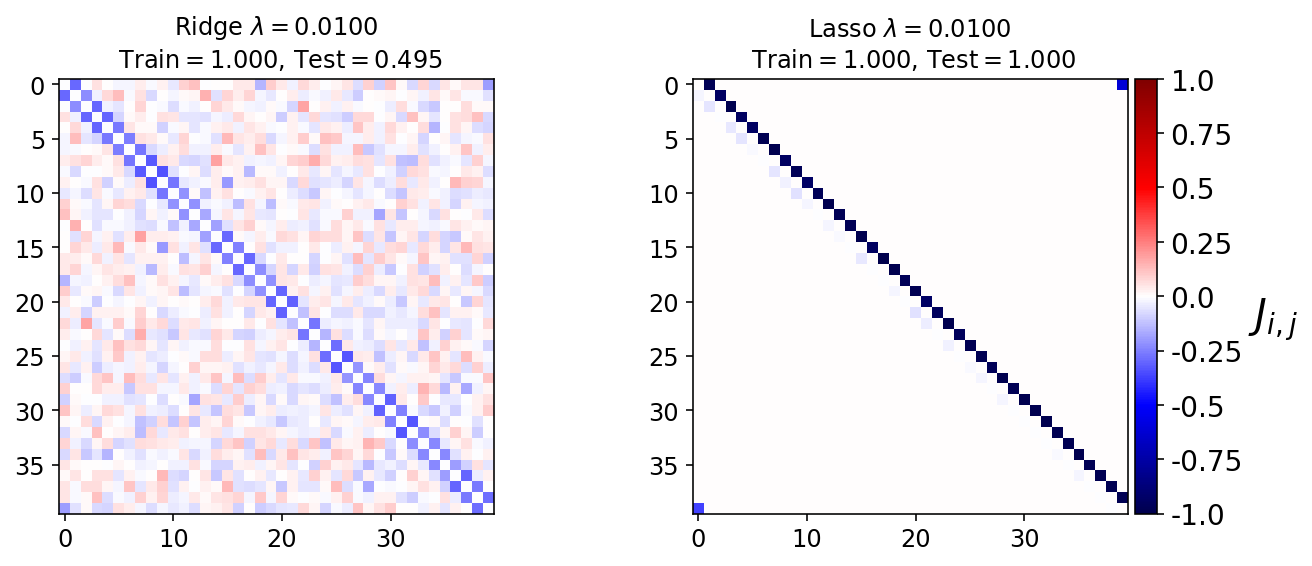

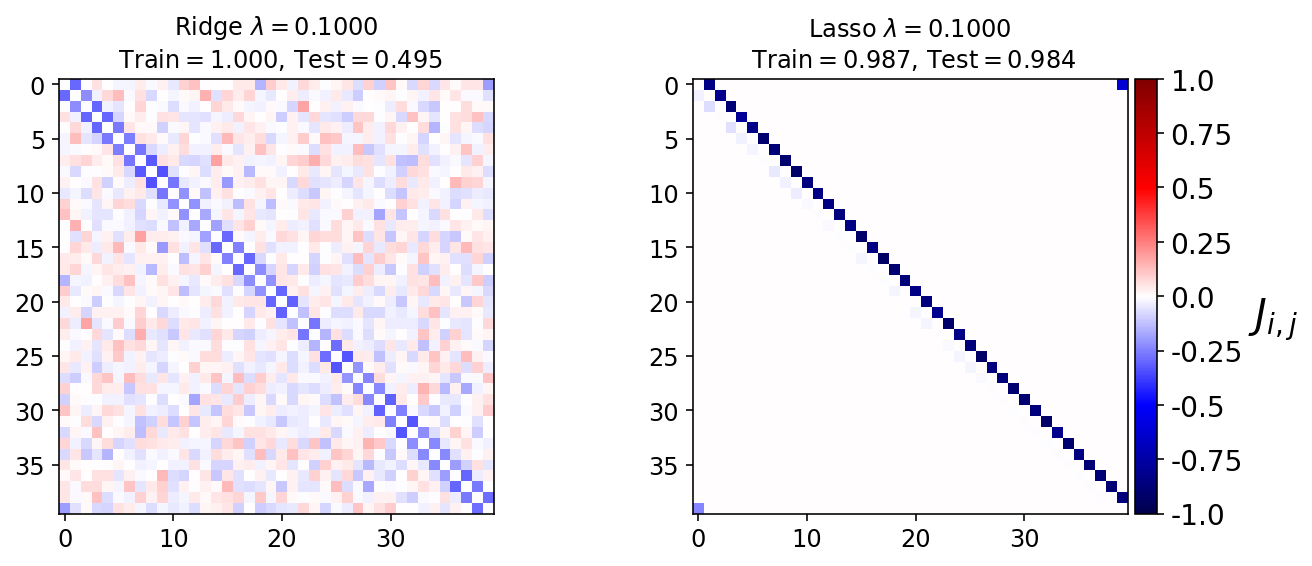

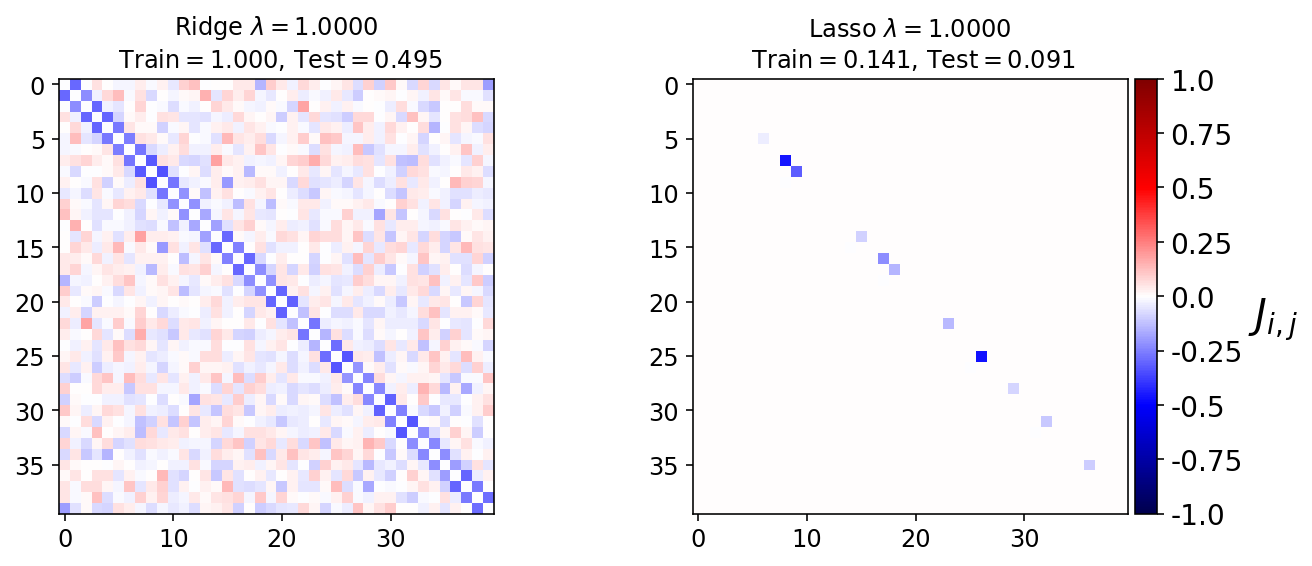

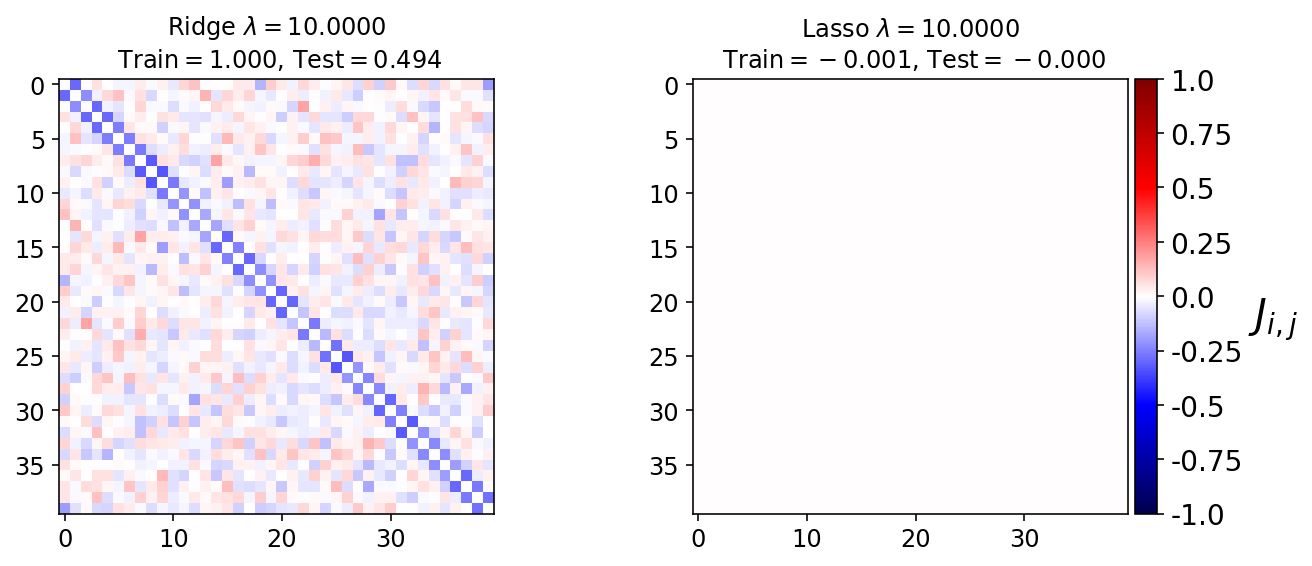

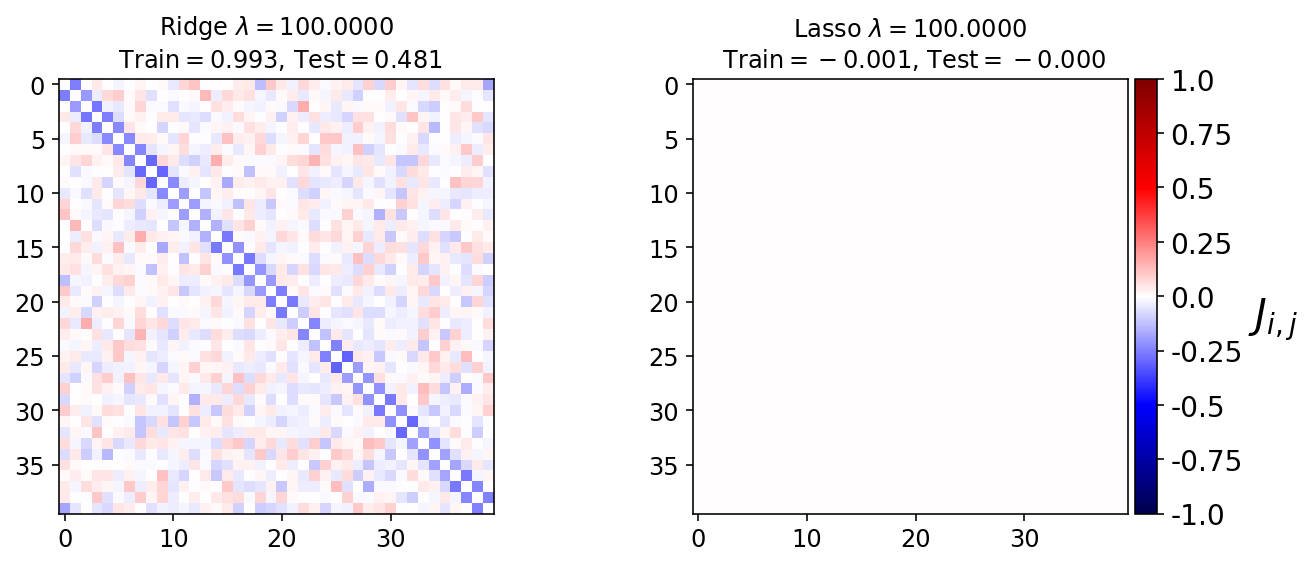

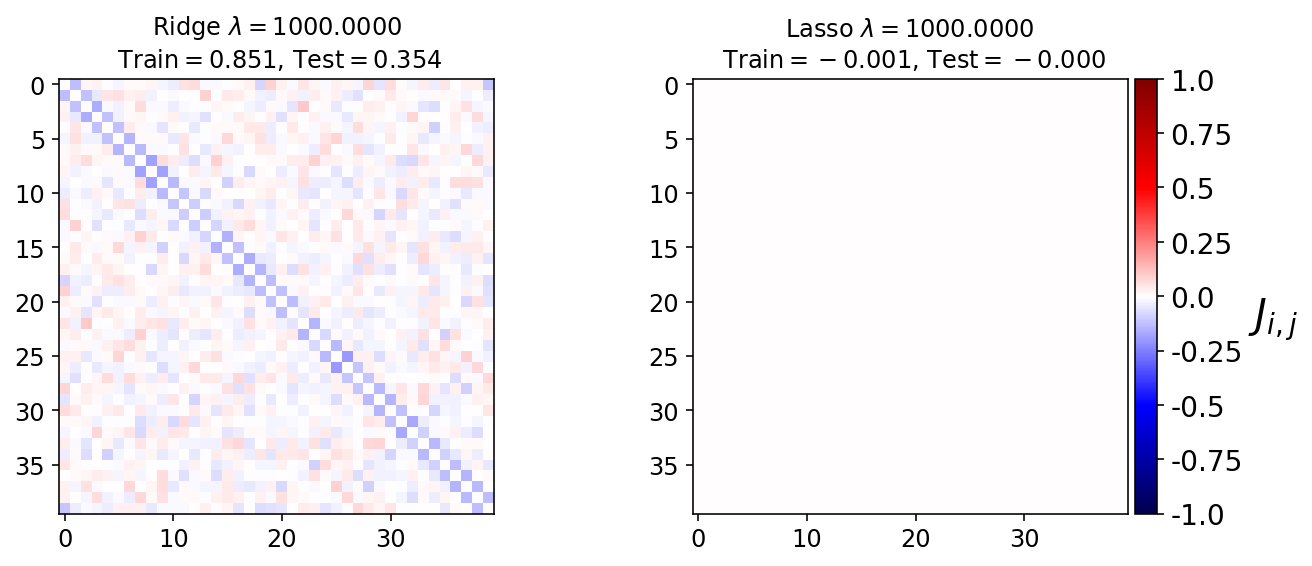

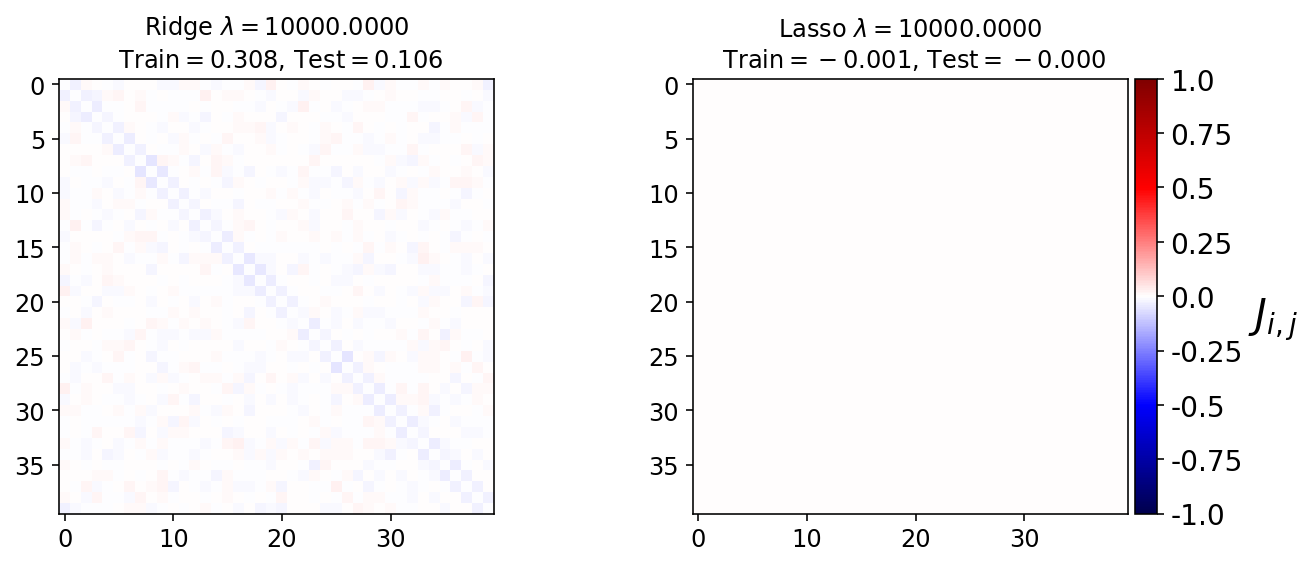

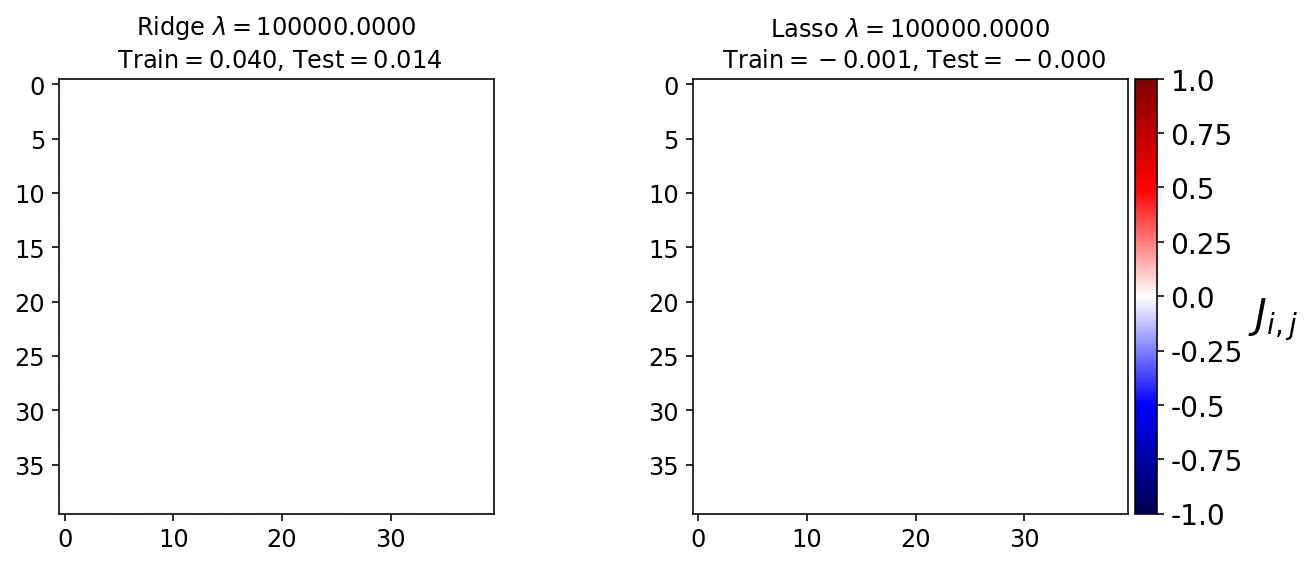

In [6]:
n = 10
# set regularisation strength values
lmbdas = np.logspace(-4, 5, n)

ols.fit(X_train, y_train)  # fit model
coef_ols = np.tile(ols.coef_, (n, 1))  # store weights

# use the coefficient of determination R^2 as the performance of prediction.
r2_train_ols = np.full(n, ols.r2(X_train, y_train))
r2_test_ols = np.full(n, ols.r2(X_test, y_test))

r2_train_ridge = np.zeros(n)
r2_test_ridge = np.zeros(n)

r2_train_lasso = np.zeros(n)
r2_test_lasso = np.zeros(n)

coefs_ridge = []
coefs_lasso = []

for i, lmbda in enumerate(lmbdas):
    # apply RIDGE regression
    ridge.set_penalty(lmbda)             # set regularisation parameter
    ridge.fit(X_train, y_train)          # fit model
    coefs_ridge.append(ridge.coef_)      # store weights
    # use the coefficient of determination R^2 as the performance of prediction
    r2_train_ridge[i] = ridge.r2(X_train, y_train)
    r2_test_ridge[i] = ridge.r2(X_test, y_test)

    # apply LASSO regression
    lasso.set_penalty(lmbda)             # set regularisation parameter
    lasso.fit(X_train, y_train)          # fit model
    coefs_lasso.append(lasso.coef_)      # store weights
    # use the coefficient of determination R^2 as the performance of prediction
    r2_train_lasso[i] = lasso.r2(X_train, y_train)
    r2_test_lasso[i] = lasso.r2(X_test, y_test)

    J_ridge = np.array(ridge.coef_).reshape((L, L))
    J_lasso = np.array(lasso.coef_).reshape((L, L))

    cmap_args = dict(vmin=-1., vmax=1., cmap='seismic')
    fig, axarr = plt.subplots(nrows=1, ncols=2)

    axarr[0].imshow(J_ridge, **cmap_args)
    axarr[0].set_title('Ridge $\lambda={:.4f}$\n Train$={:.3f}$, Test$={:.3f}$'.format(
        lmbda, r2_train_ridge[i], r2_test_ridge[i]))

    im = axarr[1].imshow(J_lasso, **cmap_args)
    axarr[1].set_title('Lasso $\lambda={:.4f}$\n Train$={:.3f}$, Test$={:.3f}$'.format(
        lmbda, r2_train_lasso[i], r2_test_lasso[i]))

    divider = make_axes_locatable(axarr[1])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0 + 0.25, 0.25), fontsize=14)
    cbar.set_label('$J_{i,j}$', labelpad=15, y=0.5, fontsize=20, rotation=0)
    fig.subplots_adjust(right=1.5)
    
    
    text_lmbda = str(round(lmbda, 4)).replace(".", "_")
    fig.savefig(fig_path("ising_J_lmbda_{}.pdf".format(text_lmbda)), bbox_inches='tight')
    plt.show()

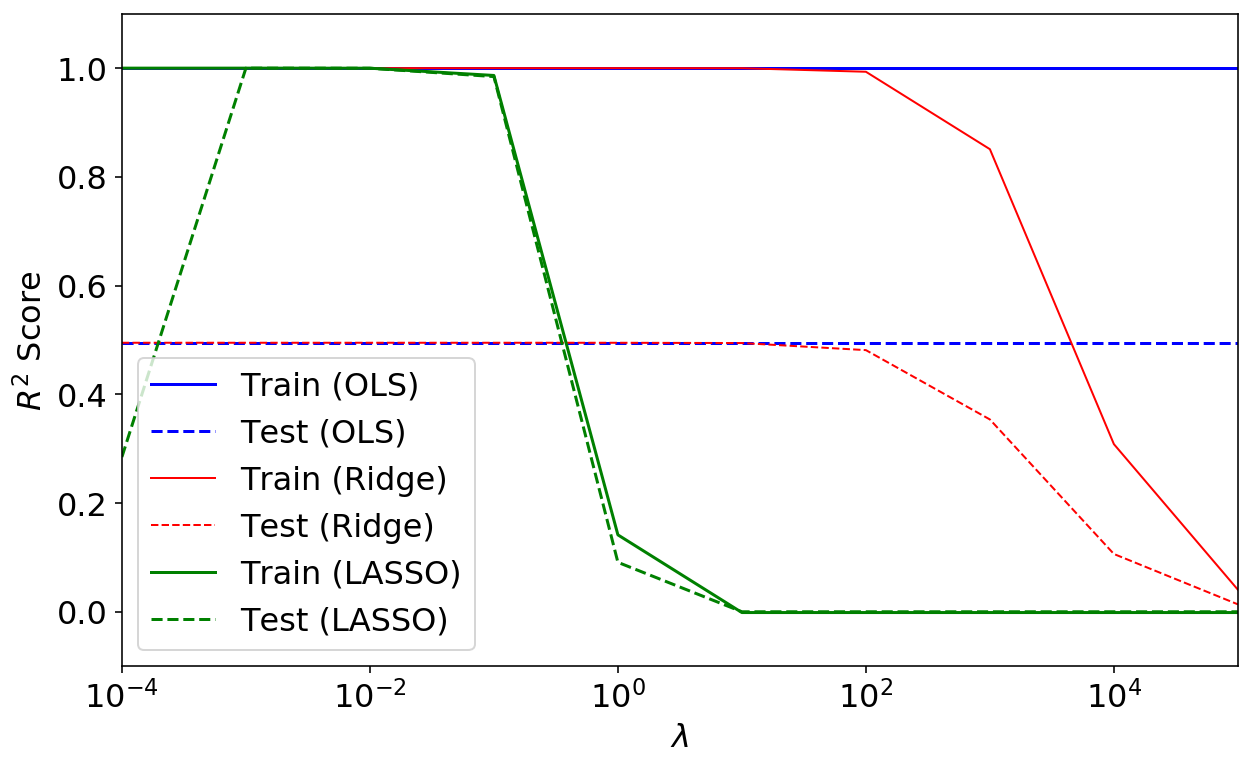

In [7]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, r2_train_ols, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, r2_test_ols,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, r2_train_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, r2_test_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, r2_train_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, r2_test_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('$R^2$ Score',fontsize=16)
plt.tick_params(labelsize=16)
fig.savefig(fig_path("ising1D_r2_vs_lmbda.pdf"))
plt.show()

In [8]:
# np.random.seed(42)

L = 4     # system size
N = 500  # number of points
data, target = generate_1Ddata(L, N)
target = target + np.random.normal(0, 4.0, size=N)
ols = OLS(fit_intercept=False)
X_train, X_test, y_train, y_test = ols.split_data(data, target, 0.20)
# print("fit")
# coeff = ols.fit(X_train, y_train)
# print("predict")
# ypredict = ols.predict(X_test)
print("bias-variance")
bias_variance(ols, X_train, y_train, 20, .2)
# print(coeff)
# print(ypredict[-1])
# print(ols.mse)
# print(ols.r2)

(500, 16)
bias-variance
y_test: (80, 1), y_pred: (80, 20)
[[-0.03095856]
 [-0.12367351]
 [ 0.20364392]
 [ 0.15366488]
 [-0.12367351]
 [-3.16195142]
 [-0.88589957]
 [-0.12367351]
 [ 0.20364392]
 [-0.88589957]
 [-0.12367351]
 [ 0.15366488]
 [ 3.8515671 ]
 [-1.78012635]
 [ 3.8515671 ]
 [-1.78012635]
 [-0.03095856]
 [-0.12367351]
 [-0.12367351]
 [ 0.15366488]
 [-0.12367351]
 [ 3.8515671 ]
 [ 0.15366488]
 [-0.12367351]
 [ 0.20364392]
 [-1.78012635]
 [ 0.15366488]
 [-3.16195142]
 [ 0.20364392]
 [-0.12367351]
 [-1.78012635]
 [-0.88589957]
 [-1.78012635]
 [-1.78012635]
 [ 3.8515671 ]
 [ 0.15366488]
 [-0.12367351]
 [-3.16195142]
 [-3.16195142]
 [ 0.15366488]
 [-1.78012635]
 [-1.78012635]
 [ 0.20364392]
 [ 0.20364392]
 [ 3.8515671 ]
 [-0.12367351]
 [-0.88589957]
 [ 0.20364392]
 [-3.16195142]
 [ 3.8515671 ]
 [-3.16195142]
 [-0.03095856]
 [-0.12367351]
 [-1.78012635]
 [ 0.15366488]
 [-0.12367351]
 [-0.12367351]
 [-0.88589957]
 [-0.03095856]
 [-1.78012635]
 [-0.88589957]
 [ 3.8515671 ]
 [-0.8858995